In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip '/content/drive/My Drive/DeepVessel Results_MICCAI.zip'

### Data preparation

In [0]:
import os
from glob import glob
import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

import torchvision
from torchvision.transforms import transforms

In [4]:
print(os.listdir('DeepVessel Results_MICCAI/'))

['MICCAI_for_STARE_data', 'MICCAI_for_CHASE_DB1', 'MICCAI_for_DRIVE_data']


### Dataset and dataloader

In [0]:
class VesselDataset(Dataset):
    def __init__(self, root_dir, im_transforms, m_transforms):
        self.root_dir = root_dir
        self.im_transforms = im_transforms
        self.m_transforms = m_transforms
        self.images = data[1:][::3]
        self.masks = data[::3]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        image = np.array(image, dtype=np.uint8)

        mask = Image.open(self.masks[idx])
        mask = np.array(mask, dtype=np.uint8)
        
        image = self.im_transforms(image)
        mask = self.m_transforms(mask)
        
        return image, mask

In [0]:
img_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((312, 312)),
    transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

mask_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((312, 312)),
    transforms.ToTensor()
    #!!!
])

# train/test dataset & dataloader
data = sorted(glob('DeepVessel Results_MICCAI/*/*'))

train_dataset = VesselDataset(root_dir=data[:-15],
                        im_transforms=img_aug, 
                        m_transforms=mask_aug)

test_dataset = VesselDataset(root_dir=data[-15:],
                        im_transforms=img_aug, 
                        m_transforms=mask_aug)

train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=5, shuffle=True)

### Data checking


In [7]:
data, target= next(iter(train_loader))
data.shape, target.shape

(torch.Size([4, 3, 312, 312]), torch.Size([4, 1, 312, 312]))

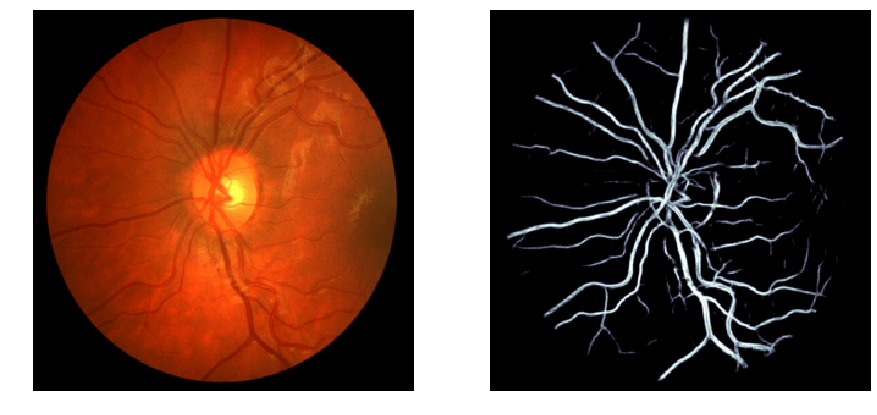

In [8]:
img = data[1,:,:].numpy().transpose(1,2,0)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225] 
img = (img*std+mean).astype(np.float32)
mask = target[1,0,:].numpy()
fig, ax = plt.subplots(nrows=1, ncols=2,sharey=True, figsize=(15,15))
ax[0].imshow(np.clip(img, 0, 255));
ax[1].imshow(mask,cmap='bone');
ax[0].axis('off');
ax[1].axis('off');

### Vanila UNet

In [0]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))   


class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_classes,1)#,1
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        out = torch.sigmoid(out)
        
        return out
    
model = UNet(n_classes=1).cuda()

### Loss and optimizer

In [0]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()


def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score
    
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=40, verbose=True)

### Training model

In [15]:
# Training model
num_epochs=200
for epoch in range(num_epochs):
    #print(time.ctime(), 'Epoch:', epoch)
    for batch_i, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        # Forward pass
        outputs = model(data)
        loss = soft_dice_loss(outputs, target)
        # Backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step(loss.item())
    # logging
    print('Epoch {}/{},  Loss: {:.4f}'
              .format(epoch+1, num_epochs,  loss.item()))

# Weights
torch.save(model.state_dict(), 'unet.pt')

Epoch 1/200,  Loss: 0.8184
Epoch 2/200,  Loss: 0.8137
Epoch 3/200,  Loss: 0.8112
Epoch 4/200,  Loss: 0.8252
Epoch 5/200,  Loss: 0.7906
Epoch 6/200,  Loss: 0.8132
Epoch 7/200,  Loss: 0.7847
Epoch 8/200,  Loss: 0.8081
Epoch 9/200,  Loss: 0.8060
Epoch 10/200,  Loss: 0.8047
Epoch 11/200,  Loss: 0.7920
Epoch 12/200,  Loss: 0.8081
Epoch 13/200,  Loss: 0.8013
Epoch 14/200,  Loss: 0.8218
Epoch 15/200,  Loss: 0.8045
Epoch 16/200,  Loss: 0.7972
Epoch 17/200,  Loss: 0.7938
Epoch 18/200,  Loss: 0.7985
Epoch 19/200,  Loss: 0.8949
Epoch 20/200,  Loss: 0.8885
Epoch 21/200,  Loss: 0.8032
Epoch 22/200,  Loss: 0.7706
Epoch 23/200,  Loss: 0.7231
Epoch 24/200,  Loss: 0.8079
Epoch 25/200,  Loss: 0.7085
Epoch 26/200,  Loss: 0.7499
Epoch 27/200,  Loss: 0.6915
Epoch 28/200,  Loss: 0.6389
Epoch 29/200,  Loss: 0.6105
Epoch 30/200,  Loss: 0.5247
Epoch 31/200,  Loss: 0.6120
Epoch 32/200,  Loss: 0.5430
Epoch 33/200,  Loss: 0.5712
Epoch 34/200,  Loss: 0.5344
Epoch 35/200,  Loss: 0.4891
Epoch 36/200,  Loss: 0.4565
E

### Test prediction

In [0]:
model = model.eval()
for data, target in test_loader:
    data = data.cuda()
    prediction = model(data)
    break

### Prediction visualization


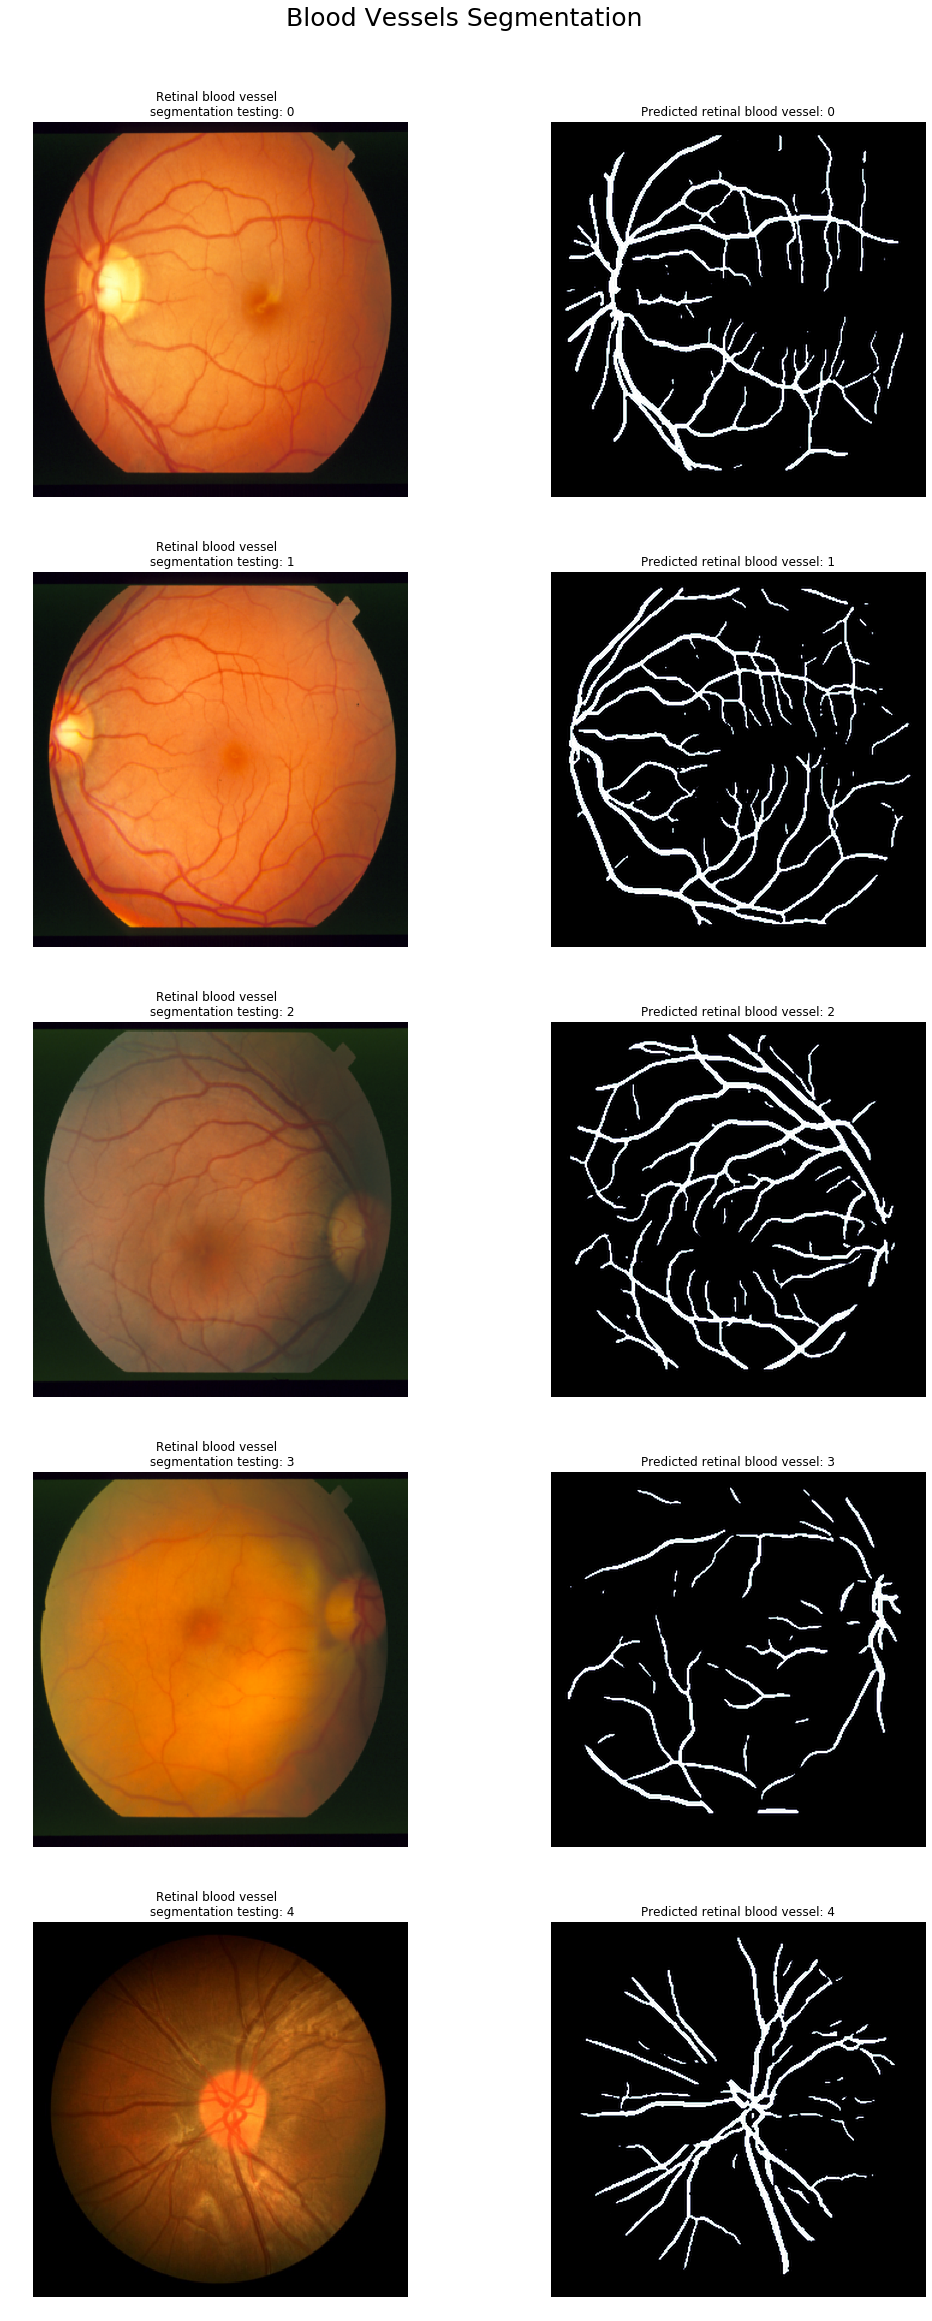

In [17]:
data = data.cpu().detach().numpy()
pred = prediction.cpu().detach().numpy()


fig, axes = plt.subplots(5, 2, figsize = (17,40))

[c_ax.axis('off') for c_ax in axes.flatten()]

for idx, (img_ax, mask_ax) in zip(range(5), axes):
    image = data.transpose(0,2,3,1)[idx,:,:,:]
    mask = pred[:,0,:,:][idx,:,:]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225] 
    image = (std*image+mean).astype(np.float32)
    img_ax.imshow(np.clip(image, 0, 255))
    mask_ax.imshow(mask, cmap = 'bone', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')

    img_ax.set_title(f'Retinal blood vessel  \n segmentation testing: {idx}')
    mask_ax.set_title(f'Predicted retinal blood vessel: {idx}')
fig.suptitle("Blood Vessels Segmentation", y=0.92, fontsize=25)
    
    
fig.savefig('model_testing.png')
    

In [0]:
!cp 'unet.pt' '/content/drive/My Drive/'